pass ms公式

$$ T_{start}-T_{end} $$

MAE公式

$$ \frac{1}{N}\sum_{i=1}^{n} \mid f_i-y_i \mid $$

MSE公式

$$ \frac{1}{N}\sum_{i=1}^{n} (f_i-y_i)^2 $$

导入相关包

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import params
import utils
#自定义处理方法
import processor


%matplotlib inline


Using TensorFlow backend.


### 探索数据集

查看视频文件

shape:


(720, 1280, 3)

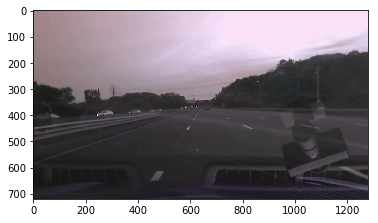

In [2]:
cap = cv2.VideoCapture(processor.get_front_file(1))
ret, frame = cap.read()
cap.release()
plt.imshow(frame)
#shape
print('shape:')
frame.shape

查看转向数据文件

In [3]:
wheel01 = utils.fetch_csv_data(processor.get_steering_file(1))
wheel01.head(10)

,ts_micro,frame,wheel
0,1464650070285914,0,-1.0
1,1464650070319247,1,-1.0
2,1464650070352581,2,-1.0
3,1464650070385914,3,-1.0
4,1464650070419247,4,-1.0
5,1464650070452581,5,-1.0
6,1464650070485914,6,-1.0
7,1464650070519247,7,-1.0
8,1464650070552581,8,-1.0
9,1464650070585914,9,-1.5


查看合并数据集

Records in epoch01_steering.csv : 1500
Records in epoch02_steering.csv : 3900
Records in epoch03_steering.csv : 2700
Records in epoch04_steering.csv : 2700
Records in epoch05_steering.csv : 2700
Records in epoch06_steering.csv : 2700
Records in epoch07_steering.csv : 2700
Records in epoch08_steering.csv : 2700
Records in epoch09_steering.csv : 2700
Records in epoch10_steering.csv : 2700
Total records from epoch01 to epoch10 : 27000


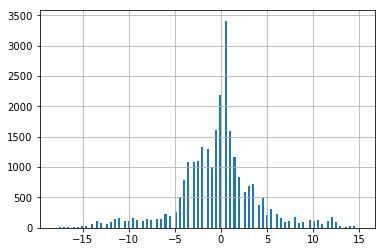

In [4]:
processor.check_dataset(1,10)

读取图片

In [22]:
def show_img(img):
    plt.imshow(img)
    plt.show()

Records in epoch01_steering.csv : 1500
Wheel of frame 1173 : 4.5


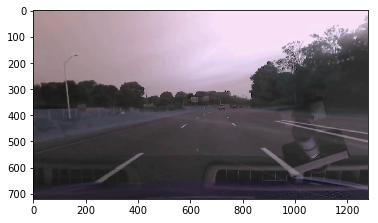

In [5]:

    
# load
sample_img = utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
epoch1 = processor.get_combine_dataset(1,1)
sample_sig = epoch1[1173]
print('Wheel of frame 1173 : '+str(sample_sig))
#show
show_img(sample_img)

改变色域

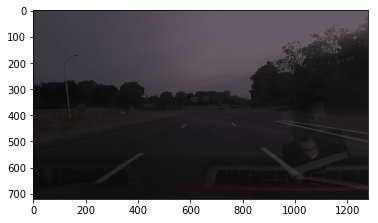

In [33]:
def change_color_space(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img[:, :, 2] = img[:, :, 2] *np.random.uniform(0.1,1)
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)

sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
#sample_img=processor.change_color_space(sample_img)
sample_img=change_color_space(sample_img)
show_img(sample_img)

平移图像

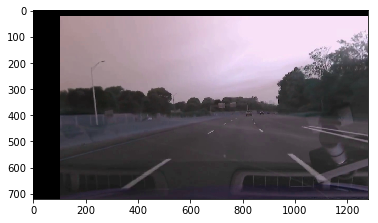

In [62]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.translate(sample_img)
show_img(sample_img)

缩放图像

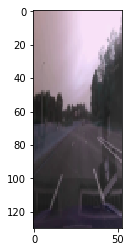

In [63]:
sample_img=utils.imread(utils.join_dir(params.parent_path+'/images/img','frame_1173.jpg'))
sample_img=processor.resize(sample_img)
show_img(sample_img)

### Checkpoint 1 is here

In [3]:
import processor
import params
import numpy as np
import modelcoder
import utils

分批读取数据集

In [4]:
all_features,all_labels = processor.load_dataset(need_ori=True)

Start to load datasets...
Processing epoch01>>>
Frames in features01.p : 3000
Records in labels01.p : 3000
Processing epoch02>>>
Frames in features02.p : 7800
Records in labels02.p : 7800
Processing epoch03>>>
Frames in features03.p : 5400
Records in labels03.p : 5400
Processing epoch04>>>
Frames in features04.p : 5400
Records in labels04.p : 5400
Processing epoch05>>>
Frames in features05.p : 5400
Records in labels05.p : 5400
Processing epoch06>>>
Frames in features06.p : 5400
Records in labels06.p : 5400
Processing epoch07>>>
Frames in features07.p : 5400
Records in labels07.p : 5400
Processing epoch08>>>
Frames in features08.p : 5400
Records in labels08.p : 5400
Processing epoch09>>>
Frames in features09.p : 5400
Records in labels09.p : 5400
Done
Length of features : 48600, length of labels : 48600


Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(2400, 64, 64, 3) (2400, 1)
Shape of test set
(600, 64, 64, 3) (600, 1)
Start training
Train on 1920 samples, validate on 480 samples
Epoch 1/10
1920/1920 [==============================] - 3s - loss: 10.7311 - val_loss: 10.9155
Epoch 2/10
1920/1920 [==============================] - 2s - loss: 10.4358 - val_loss: 10.9116
Epoch 3/10
1920/1920 [==============================] - 2s - loss: 10.4403 - val_loss: 10.9126
Epoch 4/10
1920/1920 [==============================] - 2s - loss: 10.4331 - val_loss: 10.9173
Epoch 5/10
1920/1920 [==============================] - 2s - loss: 10.4245 - val_loss: 10.9197
Epoch 6/10
1920/1920 [==============================] - 2s - loss: 10.4169 - val_loss: 10.9325
Epoch 7/10
1920/1920 [==============================] - 2s - loss: 10.4323 - val_loss: 10.9358
Epoch 8/10
1920/1920 [==============================] - 2s - los

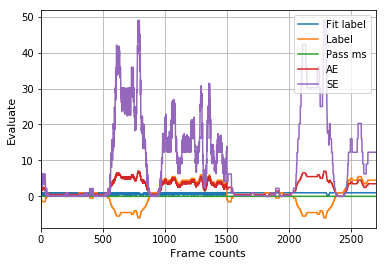

Mean absolute error is 2.564262860799829
Mean squared  error is 10.392369138270519
Mean pass ms is 0.0013897053400675455


In [3]:
model = modelcoder.get_nvidia_model()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)
processor.evaluate_final_model(model,all_features,all_labels)

In [3]:
model = modelcoder.get_nvidia_model_2()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)

Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(38880, 64, 64, 3) (38880, 1)
Shape of test set
(9720, 64, 64, 3) (9720, 1)
Start training
Train on 31104 samples, validate on 7776 samples
Epoch 1/100
31104/31104 [==============================] - 59s - loss: 20.0312 - val_loss: 19.4319
Epoch 2/100
31104/31104 [==============================] - 58s - loss: 17.9802 - val_loss: 17.4242
Epoch 3/100
31104/31104 [==============================] - 58s - loss: 16.1944 - val_loss: 16.2465
Epoch 4/100
31104/31104 [==============================] - 58s - loss: 15.1778 - val_loss: 14.5264
Epoch 5/100
31104/31104 [==============================] - 58s - loss: 14.0025 - val_loss: 13.8019
Epoch 6/100
31104/31104 [==============================] - 59s - loss: 13.2985 - val_loss: 13.2526
Epoch 7/100
31104/31104 [==============================] - 58s - loss: 12.8121 - val_loss: 13.2669
Epoch 8/100
31104/31104 [=====

31104/31104 [==============================] - 59s - loss: 2.0402 - val_loss: 16.3316
Epoch 81/100
31104/31104 [==============================] - 59s - loss: 2.0298 - val_loss: 16.1646
Epoch 82/100
31104/31104 [==============================] - 60s - loss: 1.9335 - val_loss: 16.2926
Epoch 83/100
31104/31104 [==============================] - 59s - loss: 1.9902 - val_loss: 16.6631
Epoch 84/100
31104/31104 [==============================] - 58s - loss: 2.0291 - val_loss: 16.2278
Epoch 85/100
31104/31104 [==============================] - 59s - loss: 1.8481 - val_loss: 16.2900
Epoch 86/100
31104/31104 [==============================] - 60s - loss: 1.7889 - val_loss: 16.9275
Epoch 87/100
31104/31104 [==============================] - 60s - loss: 1.6872 - val_loss: 15.9261
Epoch 88/100
31104/31104 [==============================] - 59s - loss: 1.7948 - val_loss: 17.3231
Epoch 89/100
31104/31104 [==============================] - 59s - loss: 1.9701 - val_loss: 15.3743
Epoch 90/100
31104/3110

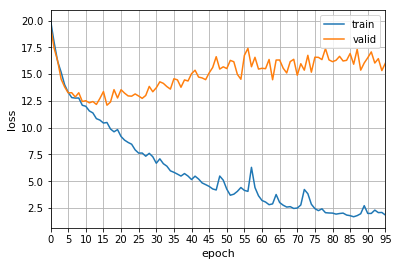

In [6]:

display_fit_result(fitted_model)

In [7]:
processor.save_model(model)

Model and weights already saved


In [ ]:
import run

### Checkpoint 2 is here

Start to create model
Model created
Start to split datasets
Split completed
Split result=========================
Shape of trainning set
(38880, 64, 64, 3) (38880, 1)
Shape of test set
(9720, 64, 64, 3) (9720, 1)
Start training
Train on 31104 samples, validate on 7776 samples
Epoch 1/10
31104/31104 [==============================] - 45s - loss: 20.6348 - val_loss: 20.9098
Epoch 2/10
31104/31104 [==============================] - 44s - loss: 20.2269 - val_loss: 20.6496
Epoch 3/10
31104/31104 [==============================] - 44s - loss: 19.9903 - val_loss: 20.2479
Epoch 4/10
31104/31104 [==============================] - 44s - loss: 19.7684 - val_loss: 19.9616
Epoch 5/10
31104/31104 [==============================] - 44s - loss: 19.6623 - val_loss: 20.2069
Epoch 6/10
31104/31104 [==============================] - 44s - loss: 19.7132 - val_loss: 20.0430
Epoch 7/10
31104/31104 [==============================] - 44s - loss: 19.7691 - val_loss: 20.3281
Epoch 8/10
31104/31104 [=============

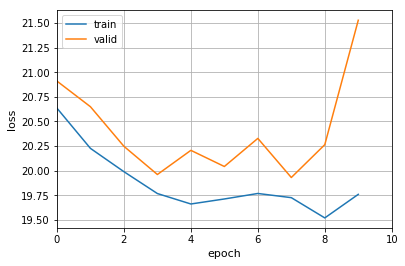

In [8]:
model = get_nvidia_model()
fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)
processor.display_fit_result(fitted_model)

## Checkpoint 3 is here

In [44]:
from keras.layers.pooling import MaxPooling2D 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation,Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Flatten
from keras import optimizers
import params

def get_nvidia_model_2():
    print("Start to create model")
    model = Sequential()
    model.add(Lambda(lambda x:x/255., input_shape=(params.FLAGS.img_h, params.FLAGS.img_w, params.FLAGS.img_c)))
    
    model.add(Convolution2D(24,(3,3), activation='elu',  padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(32,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(48,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Convolution2D(64,(3,3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(1164, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.25))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='elu'))

    model.add(Dense(1))
    adam = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=adam)
    print("Model created")
    return model

Frames in features10.p : 2700
Records in labels10.p : 2700
Start to create model
Model created
Start to evaluate model
Completed,output result...


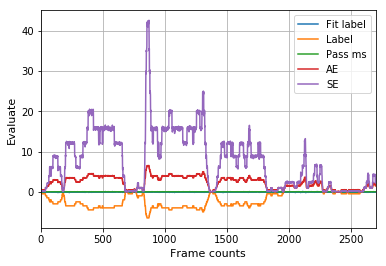

Mean absolute error is 2.3597573094279505
Mean squared  error is 7.762322427444543
Mean pass ms is 0.0058055638383936


In [45]:
import utils
import cv2
import params
import matplotlib.pyplot as plt
import time
import processor
import numpy as np
import modelcoder

features_file = utils.join_dir(params.pickle_dir,'features10.p')
labels_file = utils.join_dir(params.pickle_dir,'labels10.p')

features = processor.load_features(features_file,10)
labels = processor.load_labels(labels_file,10)

model = get_nvidia_model_2()
#fitted_model=processor.fit_model(all_features,all_labels,model,epochs=10)
processor.evaluate_final_model(model,features,labels)


In [8]:
processor.display_fit_result(fitted_model)

AttributeError: 'Sequential' object has no attribute 'history'

Records in labels10.p : 2700
Start to evaluate model
Completed,output result...


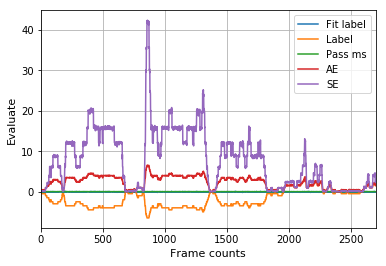

Mean absolute error is 2.359511400800267
Mean squared  error is 7.762973388488894
Mean pass ms is 0.005501296343626799


In [46]:
def get_combine_img(need_ori=False):
    video_idx = 10
    imgs = []
    tims_idx = [499,999,1499,1999,2499]
    f = 0
    cap = cv2.VideoCapture(utils.join_dir(params.data_dir,'epoch{:0>2}_front.mkv'.format(video_idx)))

    while True:
        ret, frame = cap.read()
        if not ret:
            break;
        #pre-process
        if f in tims_idx:
            frame = img_pre_process_times(frame,2)
        else:
            frame = processor.img_pre_process(frame,need_ori)
        imgs.append(frame)
        f = f+1
    cap.release()
    return imgs

def img_pre_process_times(img,times):
    for i in range(1,times+1):
        img = processor.change_color_space(img)
        img = processor.translate(img)
        img = processor.resize(img)
    return np.resize(img, (params.FLAGS.img_w, params.FLAGS.img_h, params.FLAGS.img_c))
        
features = get_combine_img()
labels = processor.load_labels(labels_file,10)

processor.evaluate_final_model(model,features,labels)

Frames in features10.p : 2700
Records in labels10.p : 2700
Start to create model
Model created
Start to evaluate model
Completed,output result...


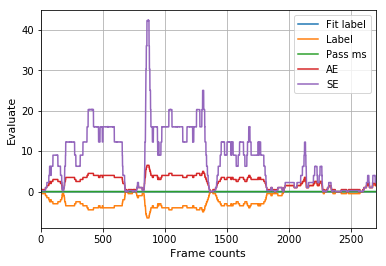

Mean absolute error is 2.374959798009232
Mean squared  error is 7.875029774578241
Mean pass ms is 0.002382227932965314


In [41]:


features_file = utils.join_dir(params.pickle_dir,'features10.p')
labels_file = utils.join_dir(params.pickle_dir,'labels10.p')

features = processor.load_features(features_file,10)
labels = processor.load_labels(labels_file,10)

model = modelcoder.get_nvidia_model()
#fitted_model = processor.fit_model(all_features,all_labels,model,epochs=10)

processor.evaluate_final_model(model,features,labels)